# Random Forest




In [2]:
# Data Processing
import pandas as pd
import numpy as np


# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
#import graphviz


import matplotlib.pyplot as plt
from datetime import datetime
import os
import seaborn as sns

# 1- Relevant components

Where i basically steal the entire code for components, and then make one big dataframe containg all the components, type, and catagory.

In [3]:
# functions to extract the relevant components from a csv file file_device contain one week exactly from Monday 00:00:01 to the next Monday
#file device : path to the file, ex : household_power_consumption/solar_panel_325_1.csv

def max_power(file_device):
    "in : path to csv file, string"
    "out : maximum power consumed, float"
    "max_power different from the power max of the file 0, because the power is sumed to resample here"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    #df['time'] = df['timestamp'].dt.time

    max_power = df['power'].max()

    return max_power

    
def use_time(file_device):
    "in : path to csv file, string"
    "out : medium time of use per usage, float"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    df['time'] = df['timestamp'].dt.time

    time_use=0
    number_of_use=0
    in_functionment=False

    for i in df.index:
        if df['power'][i]!=0: 
            time_use+=1
        if not in_functionment and df['power'][i] >= 0:
            in_functionment = True
            number_of_use += 1
        elif in_functionment and df['power'][i] <= 0:
            in_functionment = False

    use_time=time_use/number_of_use

    return use_time

    
def period_use(file_device):
    "in : path to csv file, string"
    "out : when the device is used during the day, string"
    "compter le nombre de min par période ou l'appareil est utlisé"
    "diviser par la durée de chaque période, créer une dernière catégorie non classifié (qui pourrait correspondre à toute"
    "la journée ou à deux périodes d'utilisation...)"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    df['time'] = df['timestamp'].dt.time

    use_morning=0
    use_lunch=0
    use_afternoon=0
    use_evening=0
    use_night=0
    
    night_df = df[(df['time'] >= pd.to_datetime('22:00:00').time()) | (df['time'] < pd.to_datetime('06:00:00').time())]
    for i in night_df.index:
        use_night+=night_df['power'][i]
    use_night=use_night/(8*60)
        
    morning_df = df[(df['time'] >= pd.to_datetime('06:00:00').time()) | (df['time'] < pd.to_datetime('11:00:00').time())]
    for i in morning_df.index:
        use_morning+=morning_df['power'][i]
    use_morning=use_morning/(5*60)
    
    lunch_df = df[(df['time'] >= pd.to_datetime('11:00:00').time()) | (df['time'] < pd.to_datetime('13:30:00').time())]
    for i in lunch_df.index:
        use_lunch+=lunch_df['power'][i]
    use_lunch=use_lunch/(2.5*60)
    
    afternoon_df = df[(df['time'] >= pd.to_datetime('13:30:00').time()) | (df['time'] < pd.to_datetime('18:30:00').time())]
    for i in afternoon_df.index:
        use_afternoon+=afternoon_df['power'][i]
    use_afternoon=use_afternoon/(5*60)
    
    evening_df = df[(df['time'] >= pd.to_datetime('18:30:00').time()) | (df['time'] < pd.to_datetime('22:00:00').time())]
    for i in evening_df.index:
        use_evening+=evening_df['power'][i]
    use_evening=use_evening/(3.5*60)
    
    use_time=[use_morning,use_lunch,use_afternoon,use_evening,use_night]
    use_time_sorted=sorted(use_time, reverse=True)
    second_max=use_time_sorted[1]
    if use_morning==max(use_time) and second_max<0.8*max(use_time):
        return 1
    elif use_lunch==max(use_time) and second_max<0.8*max(use_time):
        return 2
    elif use_afternoon==max(use_time) and second_max<0.8*max(use_time):
        return 3
    elif use_evening==max(use_time) and second_max<0.8*max(use_time):
        return 4
    elif use_night==max(use_time) and second_max<0.8*max(use_time):
        return 5
    else : return 6 #non classified
    

def night(file_device):
    "in : path to csv file, string"
    "out : 1 or 0 : boolean if device is used during the night or not"
    "night : from 10pm to 6am"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    df['time'] = df['timestamp'].dt.time
    
    night_df = df[(df['time'] >= pd.to_datetime('22:00:00').time()) | (df['time'] < pd.to_datetime('06:00:00').time())]
    
    for i in night_df.index:
        #test : non zero value of the power during the night
        if df['power'][i]!=0: return 1
    
    return 0
    
    
    
def number_time(file_device):
    "in : path to csv file, string"
    "out :number of times the device was used, int"
    "the device is used = period of time during which power !=0"
    
    df = pd.read_csv(file_device, parse_dates=['timestamp'])

    mseries = df.resample('1t', on='timestamp').power.sum()
    df  = pd.DataFrame({'timestamp': mseries.index, 'power': mseries.values})
    
    df['time'] = df['timestamp'].dt.time
    
    number_used=0
    
    for i in df.index:
        if i==0 and df['power'][i]!=0:
            number_used+=1 
        elif df['power'][i]!=0 and df['power'][i-1]==0:
            number_used+=1
            
    return number_used

In [4]:
#function that takes device file and extract the relevant components

def components(file_device):
    "function that takes the 0_smart_plugs_devices.csv and a device csv file and extract the 5 relevant components"
    "file device : path to the file, ex : household_power_consumption/solar_panel_325_1.csv"
    "the file must contain one week exactly from Monday 00:00:01 to the next Monday"
    "out : array of size 5"
    
    compo=np.zeros((1,5))
    
    compo[0,0]=max_power(file_device)
    compo[0,1]=use_time(file_device)
    compo[0,2]=period_use(file_device)
    compo[0,3]=night(file_device)
    compo[0,4]=number_time(file_device)
    
    return compo
    

In [5]:
%run name_and_cat.ipynb

directory = 'csv_files_1week'
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')] #select the csv files

column_names = ['Max Power', 'Use Time', 'Period Use', 'Night','Number time','Type','Category']
big_df=pd.DataFrame(columns=column_names)

for file in csv_files : #go through the csv_files
   print(file)
   compo=components(directory+'/'+file)
   type=assign_type_and_group(file)
   name_cat_array= np.array(type)
   name_cat_array_reshaped=name_cat_array.reshape(1,-1)
   new_array = np.concatenate((compo,name_cat_array_reshaped), axis=1)
   new_row_df = pd.DataFrame(new_array, columns=big_df.columns)
   big_df = pd.concat([big_df, new_row_df], ignore_index=True)

3D_printer_29_week_1_minutes.csv
3D_printer_29_week_2_minutes.csv
3D_printer_29_week_3_minutes.csv
air_conditioner_222_week_1_minutes.csv
air_conditioner_222_week_2_minutes.csv
air_conditioner_222_week_3_minutes.csv
air_purifier_293_week_1_minutes.csv
air_purifier_293_week_2_minutes.csv
air_purifier_293_week_3_minutes.csv
boiler_217_week_1_minutes.csv
boiler_217_week_2_minutes.csv
boiler_217_week_3_minutes.csv
boiler_226_week_1_minutes.csv
boiler_226_week_2_minutes.csv
boiler_226_week_3_minutes.csv
boiler_233_week_1_minutes.csv
boiler_233_week_2_minutes.csv
boiler_233_week_3_minutes.csv
boiler_233_week_4_minutes.csv
coffee_37_week_1_minutes.csv
coffee_37_week_2_minutes.csv
coffee_37_week_3_minutes.csv
coffee_54_week_1_minutes.csv
coffee_54_week_2_minutes.csv
coffee_54_week_3_minutes.csv
coffee_54_week_4_minutes.csv
coffee_97_week_1_minutes.csv
coffee_97_week_2_minutes.csv
coffee_97_week_3_minutes.csv
computer_44_week_1_minutes.csv
computer_44_week_2_minutes.csv
computer_44_week_3_minut

In [65]:

print(big_df.head(5))


   Max Power  Use Time  Period Use  Night  Number time            Type  \
0     8520.5  0.128930         2.0    1.0         16.0      3D printer   
1     8735.0  0.472188         2.0    1.0         27.0      3D printer   
2     8127.5  0.103779         2.0    1.0         10.0      3D printer   
3     1453.0  0.750205         2.0    0.0          5.0  air condtioner   
4     1155.5  1.001786         2.0    0.0          5.0  air condtioner   

     Category  
0  multimedia  
1  multimedia  
2  multimedia  
3     cooling  
4     cooling  


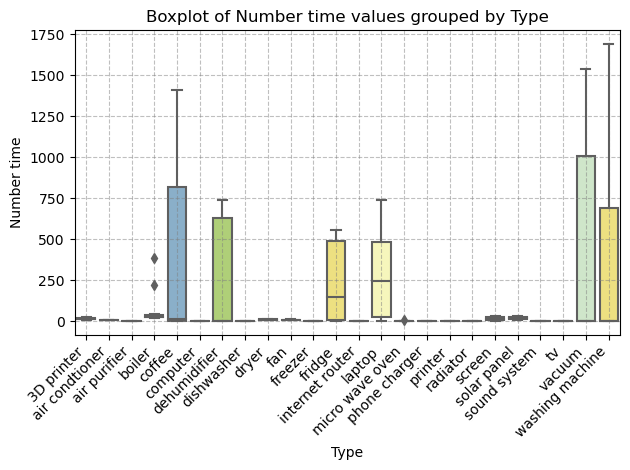

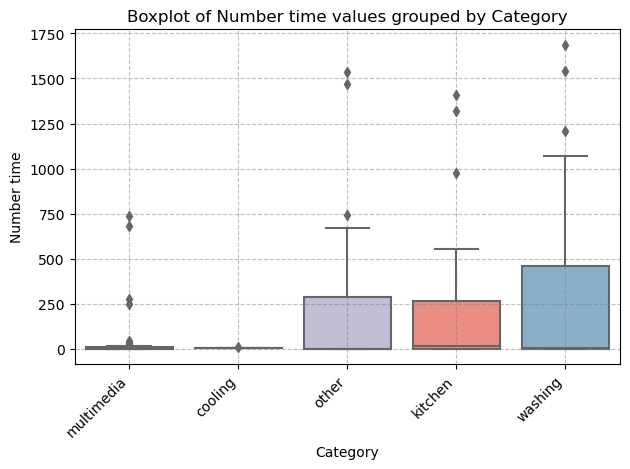

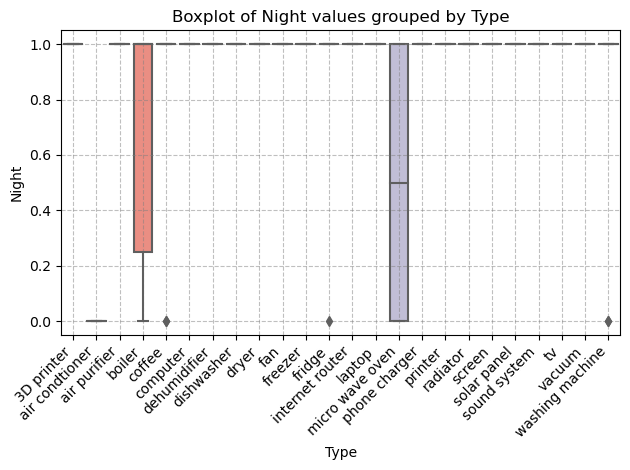

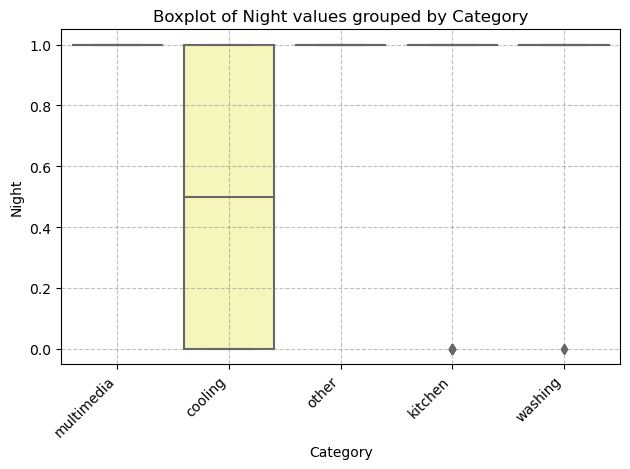

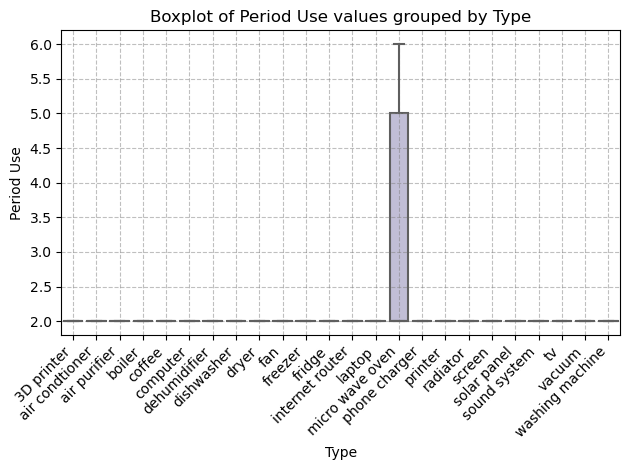

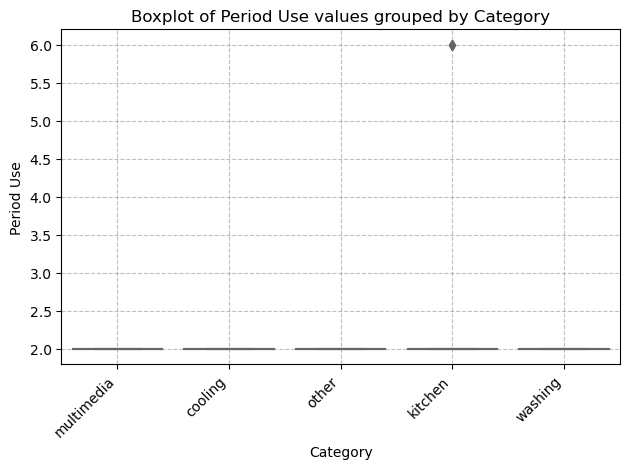

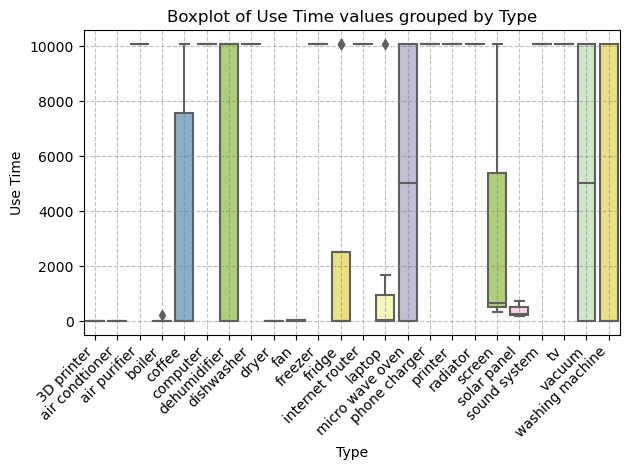

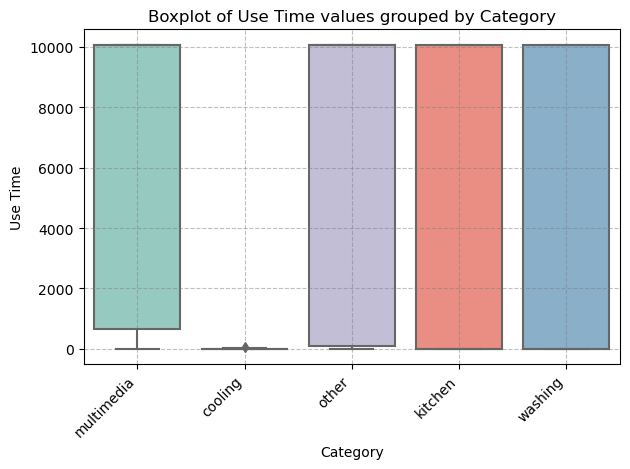

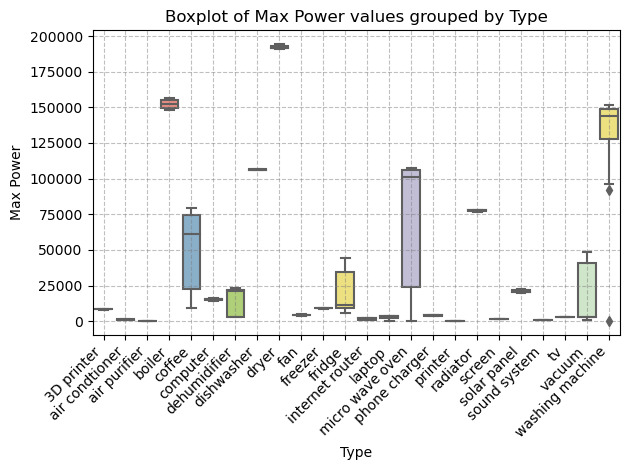

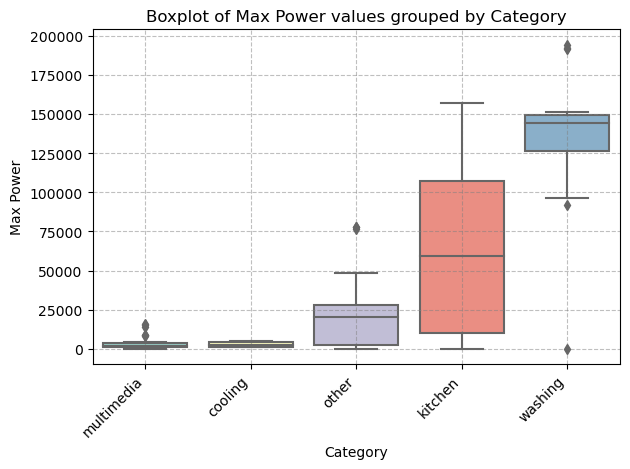

In [66]:
import seaborn as sns


#Number time ↓

#plt.figure(figsize=(12, 6))
big_df['Number time'] = pd.to_numeric(big_df['Number time'])
ax=sns.boxplot(data=big_df, x='Type', y='Number time',palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)
plt.title('Boxplot of Number time values grouped by Type')
plt.tight_layout()
plt.show()

#plt.figure(figsize=(12, 6))
big_df['Number time'] = pd.to_numeric(big_df['Number time'])
ax=sns.boxplot(data=big_df, x='Category', y='Number time',palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)
plt.title('Boxplot of Number time values grouped by Category')
plt.tight_layout()
plt.show()

#Night ↓

#plt.figure(figsize=(12, 6))
big_df['Night'] = pd.to_numeric(big_df['Night'])
ax=sns.boxplot(data=big_df, x='Type', y='Night',palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)
plt.title('Boxplot of Night values grouped by Type')
plt.tight_layout()
plt.show()

#plt.figure(figsize=(12, 6))
big_df['Night'] = pd.to_numeric(big_df['Night'])
ax=sns.boxplot(data=big_df, x='Category', y='Night',palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)
plt.title('Boxplot of Night values grouped by Category')
plt.tight_layout()
plt.show()

#Period Use ↓

#plt.figure(figsize=(12, 6))
big_df['Period Use'] = pd.to_numeric(big_df['Period Use'])
ax=sns.boxplot(data=big_df, x='Type', y='Period Use',palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)
plt.title('Boxplot of Period Use values grouped by Type')
plt.tight_layout()
plt.show()

#plt.figure(figsize=(12, 6))
big_df['Period Use'] = pd.to_numeric(big_df['Period Use'])
ax=sns.boxplot(data=big_df, x='Category', y='Period Use',palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)
plt.title('Boxplot of Period Use values grouped by Category')
plt.tight_layout()
plt.show()

#Use Time ↓

#plt.figure(figsize=(12, 6))
big_df['Use Time'] = pd.to_numeric(big_df['Use Time'])
ax=sns.boxplot(data=big_df, x='Type', y='Use Time',palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)
plt.title('Boxplot of Use Time values grouped by Type')
plt.tight_layout()
plt.show()

#plt.figure(figsize=(12, 6))
big_df['Use Time'] = pd.to_numeric(big_df['Use Time'])
ax=sns.boxplot(data=big_df, x='Category', y='Use Time',palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)
plt.title('Boxplot of Use Time values grouped by Category')
plt.tight_layout()
plt.show()

#MAX POWER ↓

#plt.figure(figsize=(12, 6))
big_df['Max Power'] = pd.to_numeric(big_df['Max Power'])
ax=sns.boxplot(data=big_df, x='Type', y='Max Power',palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)
plt.title('Boxplot of Max Power values grouped by Type')
plt.tight_layout()
plt.show()

#plt.figure(figsize=(12, 6))
big_df['Max Power'] = pd.to_numeric(big_df['Max Power'])
ax=sns.boxplot(data=big_df, x='Category', y='Max Power',palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)
plt.title('Boxplot of Max Power values grouped by Category')
plt.tight_layout()
plt.show()


# 2- Random Forest and classification

We now have one dataframe containing both the features, as well as the types and catagories.
We facotrize the type and catagories 

In [96]:
%run name_and_cat.ipynb

X = big_df.iloc[:,0:5].values
y=big_df["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=13)

string_to_count = 'air conditioner'

# Count the occurrences in the 'fruits' column
count = y_test.value_counts().get(string_to_count, 0)

print(f"The string '{string_to_count}' occurs {count} times in the 'column' column.")

The string 'air conditioner' occurs 0 times in the 'column' column.


next is to try and optimize to find the best number of n-estimators as well as number of features.

### Random Forest with Appliances(Type)

1. Evaluating max_features

Best max_features: 5
Highest OOB score: 0.7070707070707071


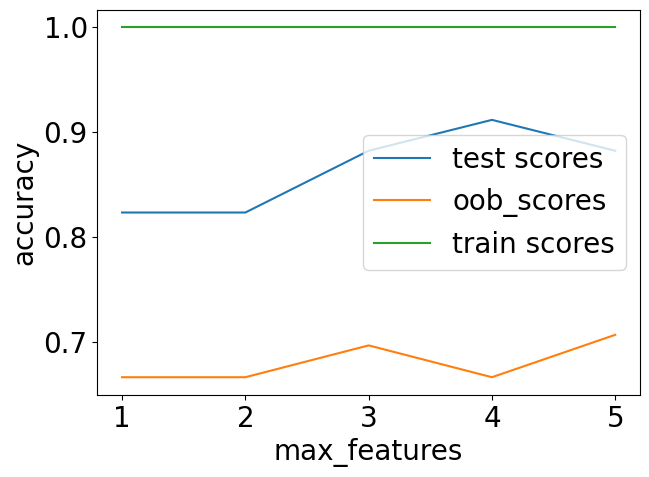

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

train_scores = []
test_scores = []
oob_scores = []

feature_range = range(1, 6)
for max_features in feature_range:
    rf = RandomForestClassifier(max_features=max_features, oob_score=True, n_estimators=200, random_state=13)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

plt.figure(figsize=(7,5))
plt.plot(feature_range, test_scores, label="test scores")
plt.plot(feature_range, oob_scores, label="oob_scores")
plt.plot(feature_range, train_scores, label="train scores")
plt.legend(fontsize=20, loc='best')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("max_features", fontsize=20)

# Convert the lists to NumPy arrays for easier manipulation
train_scores_np = np.array(train_scores)
test_scores_np = np.array(test_scores)
oob_scores_np = np.array(oob_scores)

# Find the index of the maximum oob score
max_oob_score_index = np.argmax(oob_scores_np)

# Retrieve the corresponding value of max_features and its associated oob score
best_max_features = feature_range[max_oob_score_index]
best_oob_score = oob_scores_np[max_oob_score_index]

print("Best max_features:", best_max_features)
print("Highest OOB score:", best_oob_score)


2. Evaluating n_estimators


c:\Users\bayin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bayin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bayin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bayin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bayin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probab

Best n_estimators: 13
Highest OOB score: 0.6262626262626263


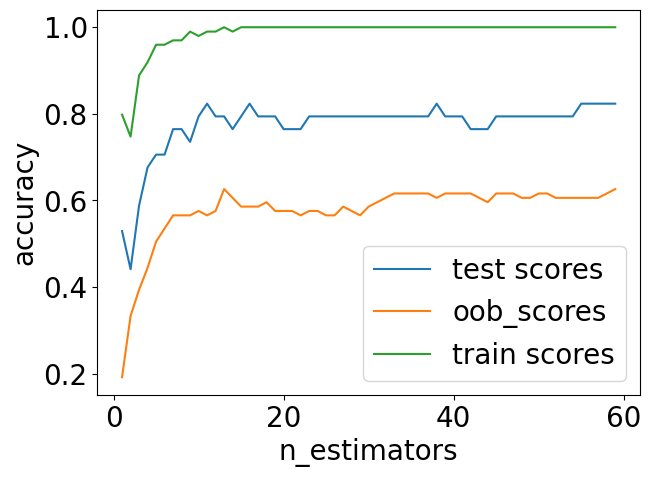

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

train_scores = []
test_scores = []
oob_scores = []

n_estimators_range = range(1, 60, 1)
for n_estimators in n_estimators_range:
    rf = RandomForestClassifier(max_features='auto', oob_score=True, n_estimators=n_estimators, random_state=13)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

plt.figure(figsize=(7,5))
plt.plot(n_estimators_range, test_scores, label="test scores")
plt.plot(n_estimators_range, oob_scores, label="oob_scores")
plt.plot(n_estimators_range, train_scores, label="train scores")
plt.legend(fontsize=20, loc='best')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("n_estimators", fontsize=20)

# Convert the lists to NumPy arrays for easier manipulation
train_scores_np = np.array(train_scores)
test_scores_np = np.array(test_scores)
oob_scores_np = np.array(oob_scores)

# Find the index of the maximum oob score
max_oob_score_index = np.argmax(oob_scores_np)

# Retrieve the corresponding value of n_estimators and its associated oob score
best_n_estimators = n_estimators_range[max_oob_score_index]
best_oob_score = oob_scores_np[max_oob_score_index]

print("Best n_estimators:", best_n_estimators)
print("Highest OOB score:", best_oob_score)


3. Evaluating max_depth


Best max_depth: 12
Highest OOB score: 0.6767676767676768


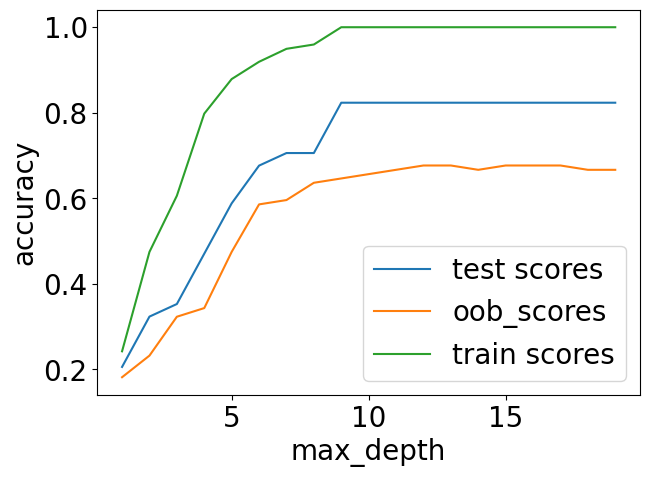

In [70]:
train_scores = []
test_scores = []
oob_scores = []

max_depth_range = range(1, 21, 1)
for max_depth in max_depth_range:
    rf = RandomForestClassifier(max_features='auto', oob_score=True, n_estimators=200, max_depth=max_depth, random_state=13)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

plt.figure(figsize=(7,5))
plt.plot(max_depth_range[:-1], test_scores[:-1], label="test scores")
plt.plot(max_depth_range[:-1], oob_scores[:-1], label="oob_scores")
plt.plot(max_depth_range[:-1], train_scores[:-1], label="train scores")
plt.legend(fontsize=20, loc='best')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("max_depth", fontsize=20)

# Convert the lists to NumPy arrays for easier manipulation
train_scores_np = np.array(train_scores)
test_scores_np = np.array(test_scores)
oob_scores_np = np.array(oob_scores)

# Find the index of the maximum oob score
max_oob_score_index = np.argmax(oob_scores_np[:-1])

# Retrieve the corresponding value of max_depth and its associated oob score
best_max_depth = max_depth_range[max_oob_score_index]
best_oob_score = oob_scores_np[max_oob_score_index]

print("Best max_depth:", best_max_depth)
print("Highest OOB score:", best_oob_score)


4. Evaluating min_samples_split

Best min_samples_split: 2
Highest OOB score: 0.6666666666666666


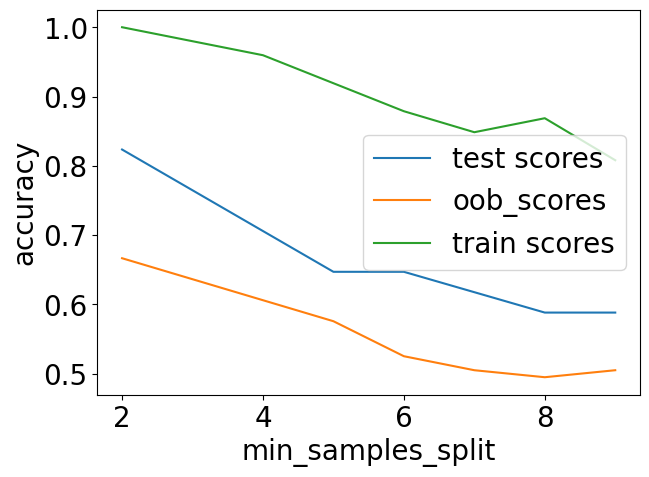

In [71]:
train_scores = []
test_scores = []
oob_scores = []

min_samples_split_range = range(2, 10, 1)
for min_samples_split in min_samples_split_range:
    rf = RandomForestClassifier(max_features='auto', oob_score=True, n_estimators=200, min_samples_split=min_samples_split, random_state=13)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

plt.figure(figsize=(7,5))
plt.plot(min_samples_split_range, test_scores, label="test scores")
plt.plot(min_samples_split_range, oob_scores, label="oob_scores")
plt.plot(min_samples_split_range, train_scores, label="train scores")
plt.legend(fontsize=20, loc='best')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("min_samples_split", fontsize=20)

# Convert the lists to NumPy arrays for easier manipulation
train_scores_np = np.array(train_scores)
test_scores_np = np.array(test_scores)
oob_scores_np = np.array(oob_scores)

# Find the index of the maximum oob score
max_oob_score_index = np.argmax(oob_scores_np)

# Retrieve the corresponding value of min_samples_split and its associated oob score
best_min_samples_split = min_samples_split_range[max_oob_score_index]
best_oob_score = oob_scores_np[max_oob_score_index]

print("Best min_samples_split:", best_min_samples_split)
print("Highest OOB score:", best_oob_score)

5. Evaluating min_samples_leaf

Best min_samples_leaf: 1
Highest OOB score: 0.6666666666666666


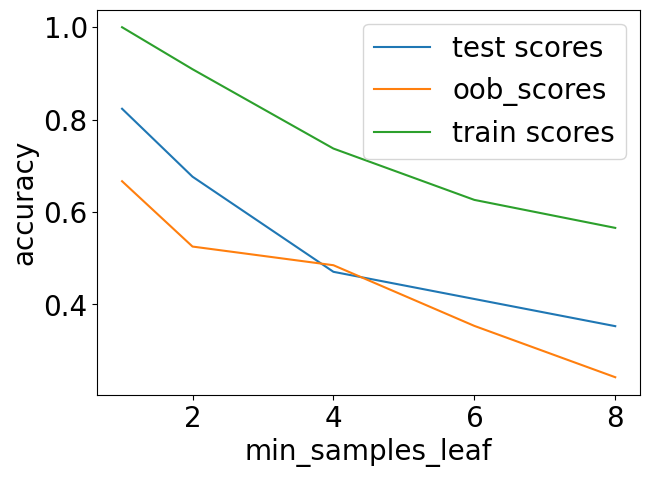

In [72]:
train_scores = []
test_scores = []
oob_scores = []

min_samples_leaf_range = [1, 2, 4, 6, 8]
for min_samples_leaf in min_samples_leaf_range:
    rf = RandomForestClassifier(max_features='auto', oob_score=True, n_estimators=200, min_samples_leaf=min_samples_leaf, random_state=13)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

plt.figure(figsize=(7,5))
plt.plot(min_samples_leaf_range, test_scores, label="test scores")
plt.plot(min_samples_leaf_range, oob_scores, label="oob_scores")
plt.plot(min_samples_leaf_range, train_scores, label="train scores")
plt.legend(fontsize=20, loc='best')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("min_samples_leaf", fontsize=20)

# Convert the lists to NumPy arrays for easier manipulation
train_scores_np = np.array(train_scores)
test_scores_np = np.array(test_scores)
oob_scores_np = np.array(oob_scores)

# Find the index of the maximum oob score
max_oob_score_index = np.argmax(oob_scores_np)

# Retrieve the corresponding value of min_samples_leaf and its associated oob score
best_min_samples_leaf = min_samples_leaf_range[max_oob_score_index]
best_oob_score = oob_scores_np[max_oob_score_index]

print("Best min_samples_leaf:", best_min_samples_leaf)
print("Highest OOB score:", best_oob_score)


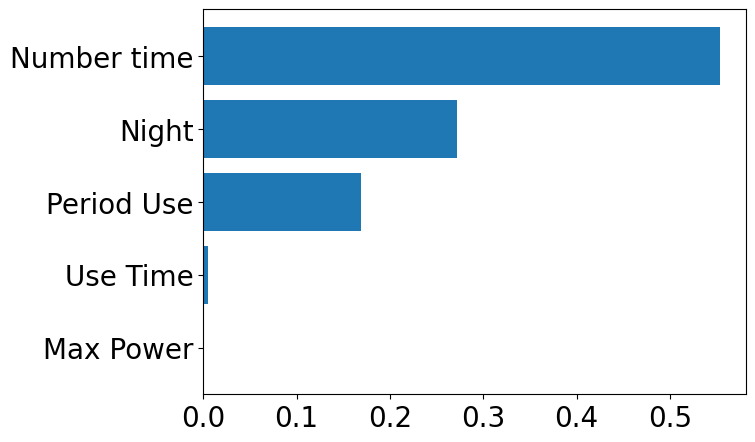

In [73]:
feat_imp=rf.feature_importances_
feat_imp.sort()
plt.figure(figsize=(7,5))
plt.barh(range(5), np.sort(rf.feature_importances_[0:5]))
plt.yticks(range(5), big_df.columns.tolist()[0:5])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

Results for Random forest type

Accuracy: 0.8529411764705882


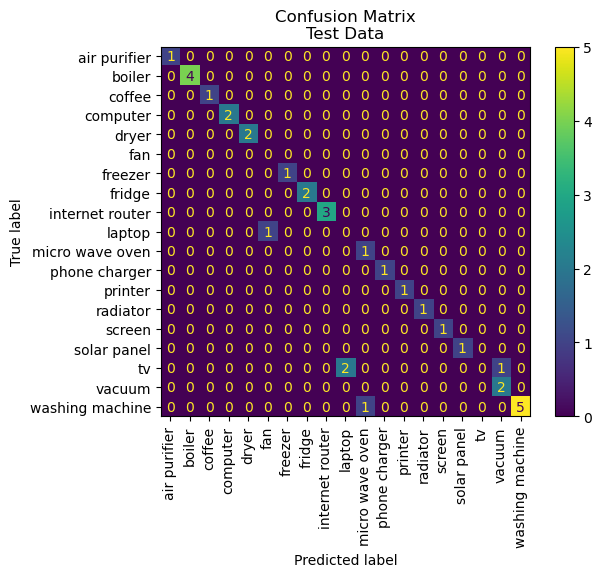

In [74]:
# Instantiate the RandomForestClassifier with the optimal parameters
rf = RandomForestClassifier(
    max_features=best_max_features,
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=13
)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred_test = rf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
confusion_matrix_test = confusion_matrix(y_test, y_pred_test)

# Display the confusion matrix
y_label = np.unique(np.concatenate((y_test, y_pred_test)))
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_test, display_labels=y_label)
cm_display.plot()
plt.xticks(rotation=90)
plt.title('Confusion Matrix\nTest Data')
plt.show()



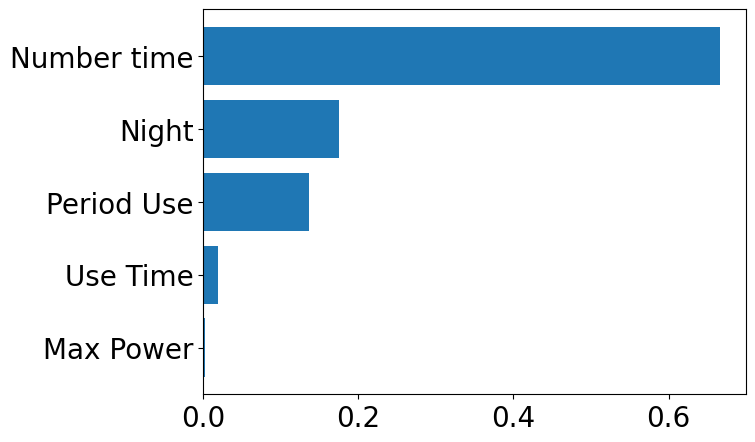

In [75]:
feat_imp=rf.feature_importances_
feat_imp.sort()
plt.figure(figsize=(7,5))
plt.barh(range(5), np.sort(rf.feature_importances_[0:5]))
plt.yticks(range(5), big_df.columns.tolist()[0:5])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

In [76]:
def calculate_metrics(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    sensitivity = np.zeros(num_classes)
    specificity = np.zeros(num_classes)

    for i in range(num_classes):
        true_positives = confusion_matrix[i, i]
        false_positives = np.sum(confusion_matrix[:, i]) - true_positives
        false_negatives = np.sum(confusion_matrix[i, :]) - true_positives

        sensitivity[i] = true_positives / (true_positives + false_negatives)
        true_negatives = np.sum(confusion_matrix) - true_positives - false_positives - false_negatives
        specificity[i] = true_negatives / (true_negatives + false_positives)

    return sensitivity, specificity

def display_metrics(sensitivity, specificity):
    print("Class\t Sensitivity\t Specificity")
    for i in range(len(sensitivity)):
        print(f"{y_label[i]}\t {sensitivity[i]:.2f}\t\t {specificity[i]:.2f}")
        
sensitivity, specificity = calculate_metrics(confusion_matrix_test)
display_metrics(sensitivity, specificity)

Class	 Sensitivity	 Specificity
air purifier	 1.00		 1.00
boiler	 1.00		 1.00
coffee	 1.00		 1.00
computer	 1.00		 1.00
dryer	 1.00		 1.00
fan	 nan		 0.97
freezer	 1.00		 1.00
fridge	 1.00		 1.00
internet router	 1.00		 1.00
laptop	 0.00		 0.94
micro wave oven	 1.00		 0.97
phone charger	 1.00		 1.00
printer	 1.00		 1.00
radiator	 1.00		 1.00
screen	 1.00		 1.00
solar panel	 1.00		 1.00
tv	 0.00		 1.00
vacuum	 1.00		 0.97
washing machine	 0.83		 1.00


C:\Users\bayin\AppData\Local\Temp\ipykernel_12588\2308181652.py:11: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity[i] = true_positives / (true_positives + false_negatives)


### Random Forest with Catagories

In [98]:
%run name_and_cat.ipynb

X = big_df.iloc[:,0:5].values
y=big_df["Category"] #This value is changed from "type" to "catagory"

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=13)

count_cooling = y_test.value_counts().get('cooling', 0)
print(count_cooling)


0


1. Evaluating max_features

Best max_features: 2
Highest OOB score: 0.8080808080808081


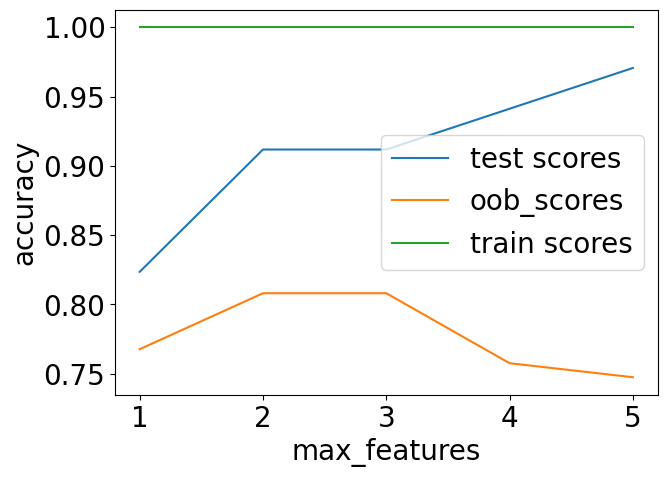

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

train_scores = []
test_scores = []
oob_scores = []

feature_range = range(1, 6)
for max_features in feature_range:
    rf = RandomForestClassifier(max_features=max_features, oob_score=True, n_estimators=200, random_state=13)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

plt.figure(figsize=(7,5))
plt.plot(feature_range, test_scores, label="test scores")
plt.plot(feature_range, oob_scores, label="oob_scores")
plt.plot(feature_range, train_scores, label="train scores")
plt.legend(fontsize=20, loc='best')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("max_features", fontsize=20)

# Convert the lists to NumPy arrays for easier manipulation
train_scores_np = np.array(train_scores)
test_scores_np = np.array(test_scores)
oob_scores_np = np.array(oob_scores)

# Find the index of the maximum oob score
max_oob_score_index = np.argmax(oob_scores_np)

# Retrieve the corresponding value of max_features and its associated oob score
best_max_features = feature_range[max_oob_score_index]
best_oob_score = oob_scores_np[max_oob_score_index]

print("Best max_features:", best_max_features)
print("Highest OOB score:", best_oob_score)


2. Evaluating n_estimators

c:\Users\bayin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bayin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bayin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bayin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\bayin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probab

Best n_estimators: 34
Highest OOB score: 0.7878787878787878


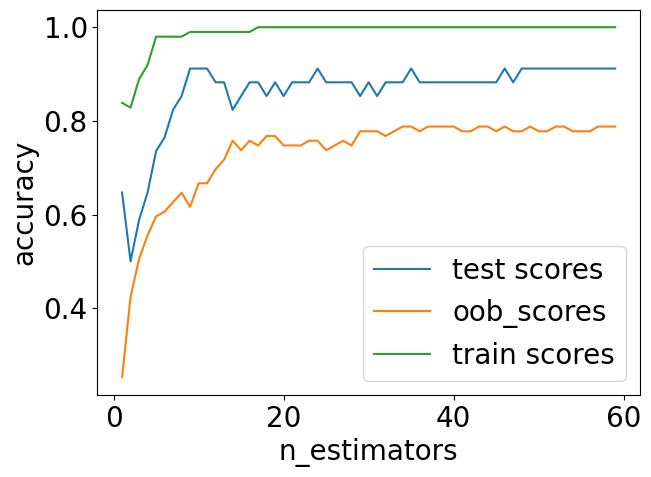

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

train_scores = []
test_scores = []
oob_scores = []

n_estimators_range = range(1, 60, 1)
for n_estimators in n_estimators_range:
    rf = RandomForestClassifier(max_features='auto', oob_score=True, n_estimators=n_estimators, random_state=13)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

plt.figure(figsize=(7,5))
plt.plot(n_estimators_range, test_scores, label="test scores")
plt.plot(n_estimators_range, oob_scores, label="oob_scores")
plt.plot(n_estimators_range, train_scores, label="train scores")
plt.legend(fontsize=20, loc='best')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("n_estimators", fontsize=20)

# Convert the lists to NumPy arrays for easier manipulation
train_scores_np = np.array(train_scores)
test_scores_np = np.array(test_scores)
oob_scores_np = np.array(oob_scores)

# Find the index of the maximum oob score
max_oob_score_index = np.argmax(oob_scores_np)

# Retrieve the corresponding value of n_estimators and its associated oob score
best_n_estimators = n_estimators_range[max_oob_score_index]
best_oob_score = oob_scores_np[max_oob_score_index]

print("Best n_estimators:", best_n_estimators)
print("Highest OOB score:", best_oob_score)

3. Evaluating max_depth


Best max_depth: 10
Highest OOB score: 0.8080808080808081


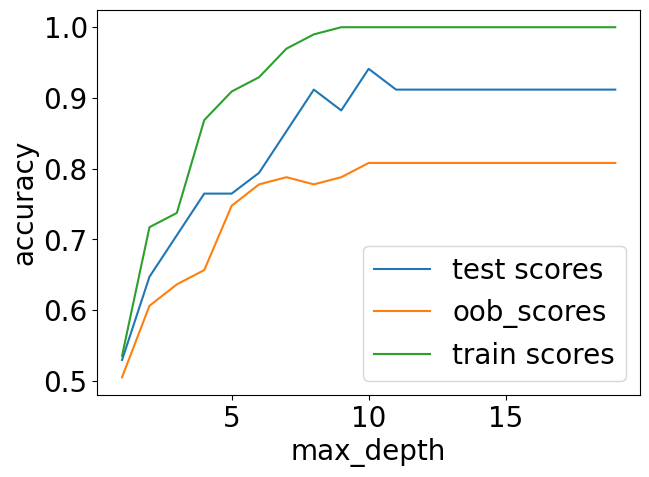

In [82]:
train_scores = []
test_scores = []
oob_scores = []

max_depth_range = range(1, 21, 1)
for max_depth in max_depth_range:
    rf = RandomForestClassifier(max_features='auto', oob_score=True, n_estimators=200, max_depth=max_depth, random_state=13)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

plt.figure(figsize=(7,5))
plt.plot(max_depth_range[:-1], test_scores[:-1], label="test scores")
plt.plot(max_depth_range[:-1], oob_scores[:-1], label="oob_scores")
plt.plot(max_depth_range[:-1], train_scores[:-1], label="train scores")
plt.legend(fontsize=20, loc='best')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("max_depth", fontsize=20)

# Convert the lists to NumPy arrays for easier manipulation
train_scores_np = np.array(train_scores)
test_scores_np = np.array(test_scores)
oob_scores_np = np.array(oob_scores)

# Find the index of the maximum oob score
max_oob_score_index = np.argmax(oob_scores_np[:-1])

# Retrieve the corresponding value of max_depth and its associated oob score
best_max_depth = max_depth_range[max_oob_score_index]
best_oob_score = oob_scores_np[max_oob_score_index]

print("Best max_depth:", best_max_depth)
print("Highest OOB score:", best_oob_score)


4. Evaluating min_samples_split

Best min_samples_split: 2
Highest OOB score: 0.8080808080808081


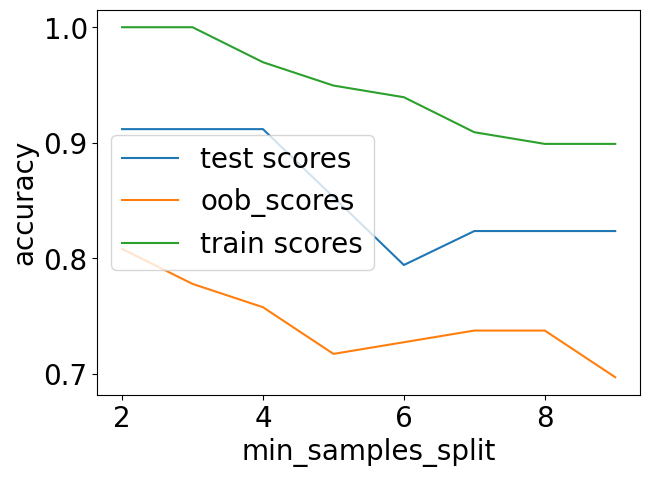

In [83]:
train_scores = []
test_scores = []
oob_scores = []

min_samples_split_range = range(2, 10, 1)
for min_samples_split in min_samples_split_range:
    rf = RandomForestClassifier(max_features='auto', oob_score=True, n_estimators=200, min_samples_split=min_samples_split, random_state=13)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

plt.figure(figsize=(7,5))
plt.plot(min_samples_split_range, test_scores, label="test scores")
plt.plot(min_samples_split_range, oob_scores, label="oob_scores")
plt.plot(min_samples_split_range, train_scores, label="train scores")
plt.legend(fontsize=20, loc='best')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("min_samples_split", fontsize=20)

# Convert the lists to NumPy arrays for easier manipulation
train_scores_np = np.array(train_scores)
test_scores_np = np.array(test_scores)
oob_scores_np = np.array(oob_scores)

# Find the index of the maximum oob score
max_oob_score_index = np.argmax(oob_scores_np)

# Retrieve the corresponding value of min_samples_split and its associated oob score
best_min_samples_split = min_samples_split_range[max_oob_score_index]
best_oob_score = oob_scores_np[max_oob_score_index]

print("Best min_samples_split:", best_min_samples_split)
print("Highest OOB score:", best_oob_score)

5. Evaluating min_samples_leaf

Best min_samples_leaf: 1
Highest OOB score: 0.8080808080808081


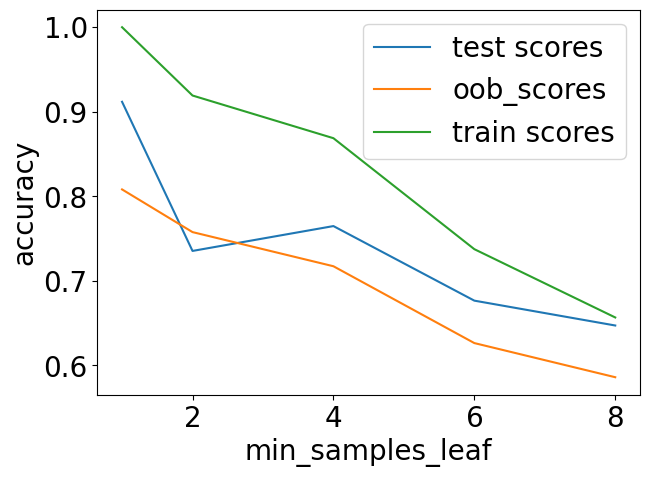

In [84]:
train_scores = []
test_scores = []
oob_scores = []

min_samples_leaf_range = [1, 2, 4, 6, 8]
for min_samples_leaf in min_samples_leaf_range:
    rf = RandomForestClassifier(max_features='auto', oob_score=True, n_estimators=200, min_samples_leaf=min_samples_leaf, random_state=13)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

plt.figure(figsize=(7,5))
plt.plot(min_samples_leaf_range, test_scores, label="test scores")
plt.plot(min_samples_leaf_range, oob_scores, label="oob_scores")
plt.plot(min_samples_leaf_range, train_scores, label="train scores")
plt.legend(fontsize=20, loc='best')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("min_samples_leaf", fontsize=20)

# Convert the lists to NumPy arrays for easier manipulation
train_scores_np = np.array(train_scores)
test_scores_np = np.array(test_scores)
oob_scores_np = np.array(oob_scores)

# Find the index of the maximum oob score
max_oob_score_index = np.argmax(oob_scores_np)

# Retrieve the corresponding value of min_samples_leaf and its associated oob score
best_min_samples_leaf = min_samples_leaf_range[max_oob_score_index]
best_oob_score = oob_scores_np[max_oob_score_index]

print("Best min_samples_leaf:", best_min_samples_leaf)
print("Highest OOB score:", best_oob_score)


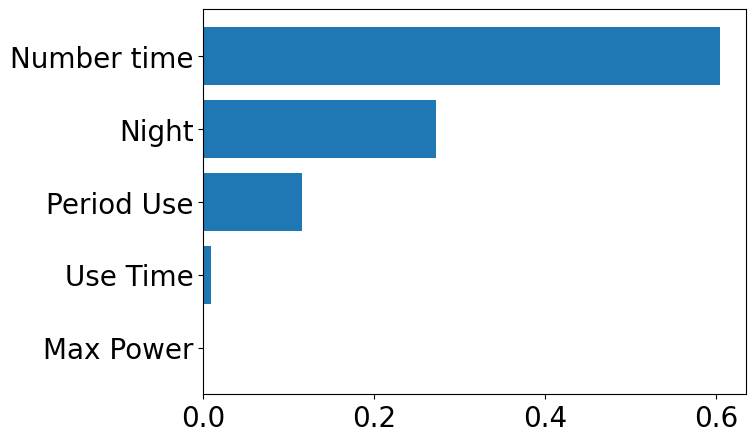

In [85]:
feat_imp=rf.feature_importances_
feat_imp.sort()
plt.figure(figsize=(7,5))
plt.barh(range(5), np.sort(rf.feature_importances_[0:5]))
plt.yticks(range(5), big_df.columns.tolist()[0:5])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

Results for Random forest type

Accuracy: 0.9117647058823529


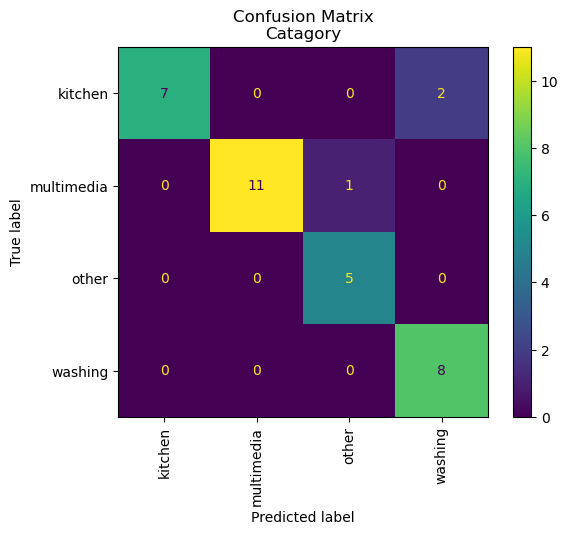

In [86]:
# Instantiate the RandomForestClassifier with the optimal parameters
rf = RandomForestClassifier(
    max_features=best_max_features,
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=13
)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred_test = rf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
confusion_matrix_test = confusion_matrix(y_test, y_pred_test)

# Display the confusion matrix
y_label = np.unique(np.concatenate((y_test, y_pred_test)))
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_test, display_labels=y_label)
cm_display.plot()
plt.xticks(rotation=90)
plt.title('Confusion Matrix\nCatagory')
plt.show()



In [87]:
def calculate_metrics(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    sensitivity = np.zeros(num_classes)
    specificity = np.zeros(num_classes)

    for i in range(num_classes):
        true_positives = confusion_matrix[i, i]
        false_positives = np.sum(confusion_matrix[:, i]) - true_positives
        false_negatives = np.sum(confusion_matrix[i, :]) - true_positives

        sensitivity[i] = true_positives / (true_positives + false_negatives)
        true_negatives = np.sum(confusion_matrix) - true_positives - false_positives - false_negatives
        specificity[i] = true_negatives / (true_negatives + false_positives)

    return sensitivity, specificity

def display_metrics(sensitivity, specificity):
    print("Class\t Sensitivity\t Specificity")
    for i in range(len(sensitivity)):
        print(f"{y_label[i]}\t {sensitivity[i]:.2f}\t\t {specificity[i]:.2f}")
        
sensitivity, specificity = calculate_metrics(confusion_matrix_test)
display_metrics(sensitivity, specificity)

Class	 Sensitivity	 Specificity
kitchen	 0.78		 1.00
multimedia	 0.92		 1.00
other	 1.00		 0.97
washing	 1.00		 0.92
